<a href="https://colab.research.google.com/github/Er-Devanshu/Tensorflow_learning/blob/main/Text_Data_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install "tensorflow-text==2.13.*"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-

In [2]:
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

## Example 1: Predict the tag for a Stack Overflow question

As a first example, you will download a dataset of programming questions from Stack Overflow. Each question (_"How do I sort a dictionary by value?"_) is labeled with exactly one tag (`Python`, `CSharp`, `JavaScript`, or `Java`). Your task is to develop a model that predicts the tag for a question. This is an example of multi-class classification—an important and widely applicable kind of machine learning problem.

To implement this task, you'll start with the simplest tools:

* `keras.utils.text_datasaet_from_directory`: for loading text-file examples.
* `keras.layers.TextVectorization`: for converting strings to token indices.


In [3]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')

dataset_dir = pathlib.Path(dataset_dir).parent

6053168/6053168 [==============================] - 0s 0us/step


In [4]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/README.md'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/train')]

In [5]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/javascript'),
 PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/python')]

The `train/csharp`, `train/java`, `train/python` and `train/javascript` directories contain many text files, each of which is a Stack Overflow question.

Print an example file and inspect the data:

In [6]:
sample_file = train_dir/'python/1755.txt'

with open(sample_file) as f:
  print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



In [7]:
batch_size = 32
seed = 42

raw_train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

In [9]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [10]:
# Create a validation set.
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [11]:
test_dir = dataset_dir/'test'

# Create a test set.
raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [12]:
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

In [14]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

In [15]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [16]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int32)


'binary' vectorized question: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,

(0.0, 1000.0)

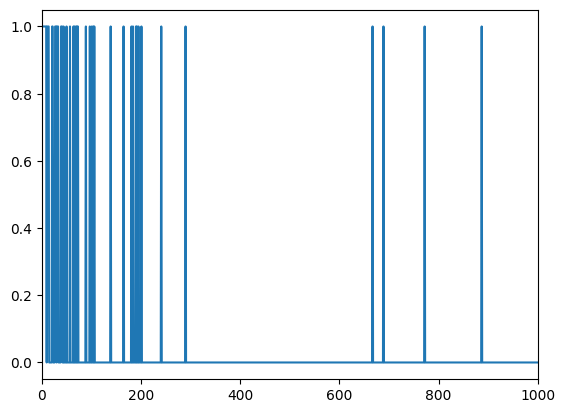

In [17]:
print("'binary' vectorized question:",
      list(binary_vectorize_layer(first_question).numpy()))

plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0,1000)

In [18]:
print("'int' vectorized question:",
      int_vectorize_layer(first_question).numpy())

'int' vectorized question: [1011  773    9 2456    8 1863 2362  690 1267    4   40    5    1 1011
  196   12   74   13   72   33    2   98  105   14    3   70 9611    3
   34  888  202  773  107    8   41  242   40   58  291   90    3  196
  191   10    2  182    6  668    6   13   30 1187   12  773   22   42
    1   28    5  140   29 5213   15   29    1   28   51    1    1    1
    7   23   30    3  291   10   67    6   32   65  185  166  102   14
    2   65    6    1  193    9 2784   45 2410    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

In [19]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  roman
313 --->  source
Vocabulary size: 10000


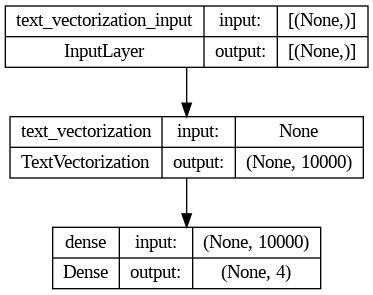

In [20]:
binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

tf.keras.utils.plot_model(binary_model, show_shapes=True)

In [21]:
bin_history = binary_model.fit(
    raw_train_ds, validation_data=raw_val_ds, epochs=10)

print()

Epoch 1/10
200/200 [==============================] - 2s 6ms/step - loss: 1.1205 - accuracy: 0.6491 - val_loss: 0.9141 - val_accuracy: 0.7750
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.7790 - accuracy: 0.8186 - val_loss: 0.7507 - val_accuracy: 0.7981
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6276 - accuracy: 0.8586 - val_loss: 0.6652 - val_accuracy: 0.8112
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5342 - accuracy: 0.8864 - val_loss: 0.6117 - val_accuracy: 0.8244
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4682 - accuracy: 0.9041 - val_loss: 0.5749 - val_accuracy: 0.8331
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4179 - accuracy: 0.9159 - val_loss: 0.5482 - val_accuracy: 0.8363
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3776 - accuracy: 0.9283 - val_loss: 0.5280 - val_accuracy: 0.8363
Epoch 

In [22]:
def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers =[]
  if vectorizer is not None:
    my_layers = [vectorizer]

  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Dropout(0.5),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])

  model = tf.keras.Sequential(my_layers)
  return model

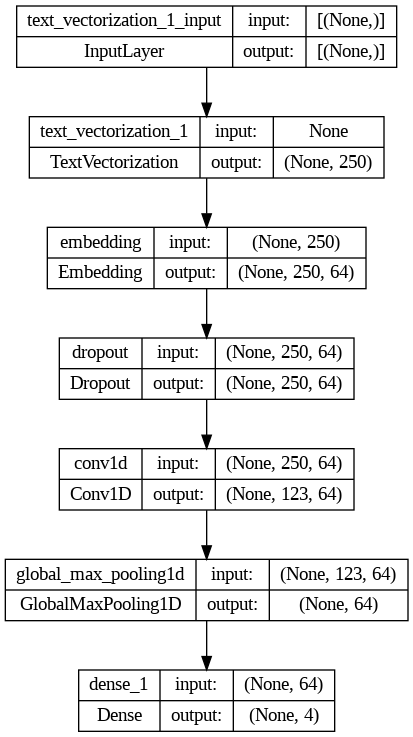

In [23]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4, vectorizer=int_vectorize_layer)

tf.keras.utils.plot_model(int_model, show_shapes=True)

In [24]:
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
int_history = int_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10
200/200 [==============================] - 8s 35ms/step - loss: 1.2553 - accuracy: 0.4220 - val_loss: 0.9294 - val_accuracy: 0.5981
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.7833 - accuracy: 0.6677 - val_loss: 0.6428 - val_accuracy: 0.7431
Epoch 3/10
200/200 [==============================] - 9s 43ms/step - loss: 0.5692 - accuracy: 0.7831 - val_loss: 0.5577 - val_accuracy: 0.7844
Epoch 4/10
200/200 [==============================] - 5s 23ms/step - loss: 0.4259 - accuracy: 0.8511 - val_loss: 0.5081 - val_accuracy: 0.8044
Epoch 5/10
200/200 [==============================] - 5s 23ms/step - loss: 0.3040 - accuracy: 0.9023 - val_loss: 0.4920 - val_accuracy: 0.8194
Epoch 6/10
200/200 [==============================] - 6s 29ms/step - loss: 0.2229 - accuracy: 0.9344 - val_loss: 0.5082 - val_accuracy: 0.8106
Epoch 7/10
200/200 [==============================] - 5s 23ms/step - loss: 0.1612 - accuracy: 0.9584 - val_loss: 0.5299 - val_accuracy: 0.8150

Text(0, 0.5, 'CE/token')

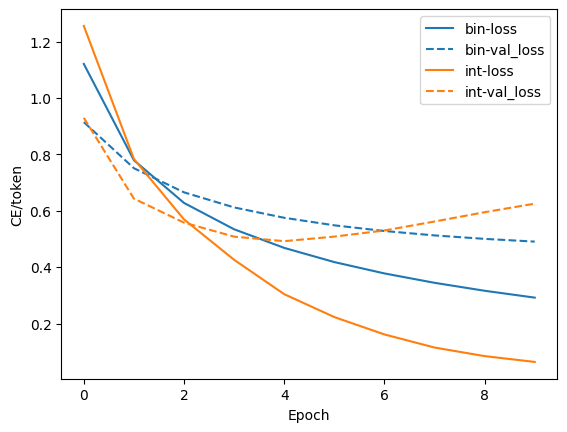

In [25]:
loss = plt.plot(bin_history.epoch, bin_history.history['loss'], label='bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color=loss[0].get_color(), label='bin-val_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')

In [26]:
binary_train_ds = raw_train_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_val_ds = raw_val_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_test_ds = raw_test_ds.map(lambda x,y: (binary_vectorize_layer(x), y))

int_train_ds = raw_train_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_val_ds = raw_val_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_test_ds = raw_test_ds.map(lambda x,y: (int_vectorize_layer(x), y))

In [27]:
binary_model.export('bin.tf')

Saved artifact at 'bin.tf'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: string Tensor, shape=(None,)
  Returns:
    float32 Tensor, shape=(None, 4)


In [28]:
loaded = tf.saved_model.load('bin.tf')
binary_model.predict(['How do you sort a list?'])
loaded.serve(tf.constant(['How do you sort a list?'])).numpy()

1/1 [==============================] - 0s 124ms/step


array([[-0.1283443 ,  0.0281615 , -0.62585783,  0.36152157]],
      dtype=float32)

<a name="example2">

## Example 2: Predict the author of Iliad translations

The following provides an example of using `tf.data.TextLineDataset` to load examples from text files, and [TensorFlow Text](https://www.tensorflow.org/text) to preprocess the data. You will use three different English translations of the same work, Homer's Iliad, and train a model to identify the translator given a single line of text.

In [29]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = utils.get_file(name, origin=DIRECTORY_URL + name)

parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir())

807992/807992 [==============================] - 0s 0us/step


[PosixPath('/root/.keras/datasets/derby.txt'),
 PosixPath('/root/.keras/datasets/cowper.txt'),
 PosixPath('/root/.keras/datasets/butler.txt')]

In [30]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64)

In [31]:
labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(str(parent_dir/file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

In [32]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

In [33]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [34]:
for text, label in all_labeled_data.take(10):
  print("Sentence: ", text.numpy())
  print("Label:", label.numpy())

Sentence:  b'And ye were eager both, but from your sires'
Label: 0
Sentence:  b'I left abundant. I shall also hence'
Label: 0
Sentence:  b'following.'
Label: 2
Sentence:  b'Fall prostrate under fury of the fire,'
Label: 0
Sentence:  b"Of Atreus' son, who now abated much"
Label: 0
Sentence:  b"'Twere better far at once to die, than live"
Label: 1
Sentence:  b'ones at home look anxiously for our coming, but the work that we came'
Label: 2
Sentence:  b'To do Atrides grace; if him thou love,'
Label: 1
Sentence:  b'Then Meges, rising, with his pointed lance'
Label: 0
Sentence:  b'Agastrophus. No steeds at his command'
Label: 0


In [35]:
class MyTokenizer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.tokenizer = tf_text.UnicodeScriptTokenizer()

  def call(self, text):
    lower_case = tf_text.case_fold_utf8(text)
    result = self.tokenizer.tokenize(lower_case)
    # If you pass a batch of strings, it will return a RaggedTensor.
    if isinstance(result, tf.RaggedTensor):
      # Convert to dense 0-padded.
      result = result.to_tensor()
    return result

In [36]:
tokenizer = MyTokenizer()

tokenized_ds = all_labeled_data.map(lambda text, label: (tokenizer(text), label))
tokenized_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [37]:
for tokens, label in tokenized_ds.take(1):
  break

print(tokens)
print()
print(label)

tf.Tensor(
[b'and' b'ye' b'were' b'eager' b'both' b',' b'but' b'from' b'your'
 b'sires'], shape=(10,), dtype=string)

tf.Tensor(0, shape=(), dtype=int64)


In [38]:
tokenized_ds = tokenized_ds.cache().prefetch(tf.data.AUTOTUNE)

vocab_count = collections.Counter()
for toks, labels in tokenized_ds.ragged_batch(1000):
  toks = tf.reshape(toks, [-1])
  for tok in toks.numpy():
    vocab_count[tok] += 1

vocab = [tok for tok, count in vocab_count.most_common(VOCAB_SIZE)]

print("First five vocab entries:", vocab[:5])
print()

First five vocab entries: [b',', b'the', b'and', b"'", b'of']



In [39]:
class MyVocabTable(tf.keras.layers.Layer):
  def __init__(self, vocab):
    super().__init__()
    self.keys = [''] + vocab
    self.values = range(len(self.keys))

    self.init = tf.lookup.KeyValueTensorInitializer(
        self.keys, self.values, key_dtype=tf.string, value_dtype=tf.int64)

    num_oov_buckets = 1

    self.table = tf.lookup.StaticVocabularyTable(self.init, num_oov_buckets)

  def call(self, x):
    result = self.table.lookup(x)
    return result

In [40]:
vocab_table = MyVocabTable(['a','b','c'])
vocab_table(tf.constant([''] + list('abcdefghi')))

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 2, 3, 4, 4, 4, 4, 4, 4])>

In [41]:
vocab_table = MyVocabTable(vocab)

preprocess_text = tf.keras.Sequential([
    tokenizer,
    vocab_table
])

In [42]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text = preprocess_text(example_text)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'And ye were eager both, but from your sires'
Vectorized sentence:  [   3  129   60  726  106    1   19   17   86 3285]


In [43]:
all_encoded_data = all_labeled_data.map(lambda text, labels:(preprocess_text(text), labels))

for ids, label in all_encoded_data.take(1):
  break

print("Ids: ", ids.numpy())
print("Label: ", label.numpy())

Ids:  [   3  129   60  726  106    1   19   17   86 3285]
Label:  0


In [44]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE).padded_batch(BATCH_SIZE)

In [45]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (64, 19)
Label batch shape:  (64,)
First text example:  tf.Tensor(
[   3  129   60  726  106    1   19   17   86 3285    0    0    0    0
    0    0    0    0    0], shape=(19,), dtype=int64)
First label example:  tf.Tensor(0, shape=(), dtype=int64)


In [46]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [47]:
model = create_model(vocab_size=VOCAB_SIZE+2, num_labels=3)

model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [48]:
tf.keras.utils.plot_model(model, show_shapes=True)

history = model.fit(train_data, validation_data=validation_data, epochs=3)

metrics = model.evaluate(validation_data, return_dict=True)

print("Loss: ", metrics['loss'])
print("Accuracy: {:2.2%}".format(metrics['accuracy']))

Epoch 1/3
697/697 [==============================] - 40s 16ms/step - loss: 0.5697 - accuracy: 0.7419 - val_loss: 0.4013 - val_accuracy: 0.8282
Epoch 2/3
697/697 [==============================] - 39s 16ms/step - loss: 0.3564 - accuracy: 0.8501 - val_loss: 0.3753 - val_accuracy: 0.8374
Epoch 3/3
79/79 [==============================] - 5s 35ms/step - loss: 0.3654 - accuracy: 0.8424
Loss:  0.36544373631477356
Accuracy: 84.24%


In [49]:
export_model = tf.keras.Sequential([
    preprocess_text,
    model
])

In [50]:
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [51]:
# Create a test dataset of raw strings.
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [52]:
loss, accuracy = export_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 [==============================] - 8s 11ms/step - loss: 0.8345 - accuracy: 0.8424
Loss:  0.8345138430595398
Accuracy: 84.24%


In [53]:
tf.saved_model.save(export_model, 'export.tf')

loaded = tf.saved_model.load('export.tf')

export_model(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

loaded(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

array([[-3.2320125 , -0.65714943,  3.3807435 ]], dtype=float32)

In [54]:
inputs = [
    "Join'd to th' Ionians with their flowing robes,",  # Label: 1
    "the allies, and his armour flashed about him so that he seemed to all",  # Label: 2
    "And with loud clangor of his arms he fell.",  # Label: 0
]

predicted_scores = export_model.predict(inputs)
predicted_labels = tf.math.argmax(predicted_scores, axis=1)

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

1/1 [==============================] - 2s 2s/step
Question:  Join'd to th' Ionians with their flowing robes,
Predicted label:  1
Question:  the allies, and his armour flashed about him so that he seemed to all
Predicted label:  2
Question:  And with loud clangor of his arms he fell.
Predicted label:  0


In [55]:
# Training set.
train_ds = tfds.load(
    'imdb_reviews',
    split='train[:80%]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.1SUN6W_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.1SUN6W_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.1SUN6W_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [56]:
# Validation set.
val_ds = tfds.load(
    'imdb_reviews',
    split='train[80%:]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

In [57]:
for review_batch, label_batch in val_ds.take(1):
  for i in range(5):
    print("Review: ", review_batch[i].numpy())
    print("Label: ", label_batch[i].numpy())

Review:  b"Instead, go to the zoo, buy some peanuts and feed 'em to the monkeys. Monkeys are funny. People with amnesia who don't say much, just sit there with vacant eyes are not all that funny.<br /><br />Black comedy? There isn't a black person in it, and there isn't one funny thing in it either.<br /><br />Walmart buys these things up somehow and puts them on their dollar rack. It's labeled Unrated. I think they took out the topless scene. They may have taken out other stuff too, who knows? All we know is that whatever they took out, isn't there any more.<br /><br />The acting seemed OK to me. There's a lot of unfathomables tho. It's supposed to be a city? It's supposed to be a big lake? If it's so hot in the church people are fanning themselves, why are they all wearing coats?"
Label:  0
Review:  b'Well, was Morgan Freeman any more unusual as God than George Burns? This film sure was better than that bore, "Oh, God". I was totally engrossed and LMAO all the way through. Carrey was

In [58]:
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [59]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [60]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)

In [61]:
# Configure datasets for performance as before.
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [62]:
model = create_model(vocab_size=VOCAB_SIZE, num_labels=1)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          20544     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 660609 (2.52 MB)
Trainable params: 660609 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [63]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [64]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
313/313 [==============================] - 14s 43ms/step - loss: 0.6157 - accuracy: 0.5897 - val_loss: 0.4381 - val_accuracy: 0.7926
Epoch 2/3
313/313 [==============================] - 12s 37ms/step - loss: 0.3757 - accuracy: 0.8293 - val_loss: 0.3381 - val_accuracy: 0.8506
Epoch 3/3
313/313 [==============================] - 12s 39ms/step - loss: 0.2811 - accuracy: 0.8810 - val_loss: 0.3135 - val_accuracy: 0.8596


In [65]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 [==============================] - 0s 6ms/step - loss: 0.3135 - accuracy: 0.8596
Loss:  0.313541054725647
Accuracy: 85.96%


In [66]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [67]:
# 0 --> negative review
# 1 --> positive review
inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
]

predicted_scores = export_model.predict(inputs)
predicted_labels = [int(round(x[0])) for x in predicted_scores]

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label)

1/1 [==============================] - 0s 109ms/step
Question:  This is a fantastic movie.
Predicted label:  1
Question:  This is a bad movie.
Predicted label:  0
Question:  This movie was so bad that it was good.
Predicted label:  0
Question:  I will never say yes to watching this movie.
Predicted label:  0
